# Imports, loading features and DB

In [1]:
import sys; sys.path.insert(0, '..')
from database.dataset import *

from general_utils.plots import plot_bboxes_over_image, simple_im_show, simple_im_show2
from metrics.metrics import get_tp_fp_fn, quick_circle_comparison, circle_comparison

from metrics.metrics import get_froc
import matplotlib.pyplot as plt

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        # big max_lesion_diam_mm needed to include clusters of mC
        max_lesion_diam_mm=10000000.0,
        partitions=['train'],
        extract_patches=False,
        min_breast_fraction_roi=0.5,
        normalize=None,
        n_jobs=-1,
)

# Classification

In [3]:
from sklearn.svm import SVC

from sklearn.metrics import f1_score, roc_auc_score, auc

from sklearn.preprocessing import MinMaxScaler


from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

In [4]:
def sensitivity(y_true, y_pred):
    TP = np.sum(y_true & y_pred)
    FN = np.sum(y_true&(~y_pred))
    if TP + FN == 0:
        return 0
    return TP/(TP + FN)

In [5]:
gabor_lbp_features = pd.concat(pd.read_pickle('../data/hough_gabor_features/gabor_train_all_14px_big_diam_size.pkl'))
all_data_df = gabor_lbp_features.sample(frac=1) # shuffle df
data = all_data_df

# needed after training to access all candidates features
data_backed_up = data.copy()

data.head(5)

,img_energy,img_entropy,img_uniformity,img_min,img_10th_perc,img_90th_perc,img_max,img_mean,img_meadian,img_inter_quartile_range,...,kurt_4,energy_5,mean_5,std_5,skew_5,kurt_5,candidate_coordinates,patch_coordinates,patch_mask_intersection,img_id
244,107.447409,6.620995,0.011766,0.691527,0.718838,0.760854,0.718838,0.740218,0.740546,0.022759,...,-0.518728,1057.248291,2.316397,0.168604,0.000659,-0.868042,"[377, 1256, 10]","((1249, 1263), (370, 384))",0,22613650
1397,52.489707,7.040581,0.008434,0.450499,0.476674,0.565527,0.476674,0.516331,0.510328,0.060719,...,-0.639983,491.558655,1.576077,0.154709,0.280768,-0.901271,"[1324, 2569, 6]","((2562, 2576), (1317, 1331))",0,24065434
194,108.064027,6.920123,0.009371,0.678555,0.707503,0.776054,0.707503,0.742050,0.741779,0.037633,...,-0.559186,1026.877197,2.280616,0.194833,-0.002524,-0.192161,"[1092, 1529, 17]","((1522, 1536), (1085, 1099))",0,22579847
316,43.814838,7.002265,0.008798,0.427727,0.452598,0.495937,0.452598,0.472501,0.471928,0.023085,...,0.870224,425.388062,1.453345,0.241110,0.382781,-0.948927,"[148, 972, 16]","((965, 979), (141, 155))",0,24065707
707,86.960175,6.951886,0.009059,0.585919,0.623900,0.701019,0.623900,0.665468,0.668828,0.035665,...,-0.349546,840.623535,2.054600,0.259840,0.385205,-0.504613,"[180, 1644, 3]","((1637, 1651), (173, 187))",0,22579847


Sampling dataset to obtain a desired `positive x negative` proportion in the training df

In [6]:
neg2pos_proportion = 1

pos_data = data[data.patch_mask_intersection>0]
neg_data = data[data.patch_mask_intersection==0].sample(neg2pos_proportion*len(pos_data))
data = pd.concat([pos_data, neg_data]).sample(frac=1)
data

,img_energy,img_entropy,img_uniformity,img_min,img_10th_perc,img_90th_perc,img_max,img_mean,img_meadian,img_inter_quartile_range,...,kurt_4,energy_5,mean_5,std_5,skew_5,kurt_5,candidate_coordinates,patch_coordinates,patch_mask_intersection,img_id
363,82.235458,6.935330,0.009319,0.574781,0.607225,0.697653,0.607225,0.646316,0.639208,0.040612,...,-0.358163,859.522339,2.025147,0.533007,0.697844,-0.480445,"[122, 515, 7]","((508, 522), (115, 129))",1,22580341
49,52.901729,7.122213,0.008017,0.424171,0.443636,0.665877,0.443636,0.510812,0.469025,0.062458,...,0.370746,757.506958,1.535289,1.227892,0.817130,0.416829,"[158, 1199, 17]","((1192, 1206), (151, 165))",196,24055203
337,92.147323,6.665463,0.011349,0.641845,0.659247,0.720761,0.659247,0.685249,0.679684,0.030352,...,-0.642185,926.887756,2.128094,0.447477,0.897514,0.470923,"[918, 1741, 10]","((1734, 1748), (911, 925))",1,22580576
1314,38.987154,6.856708,0.009631,0.407810,0.426081,0.464714,0.426081,0.445732,0.445188,0.023570,...,-0.263672,379.598602,1.386776,0.116535,0.671217,-0.080300,"[538, 2054, 13]","((2047, 2061), (531, 545))",0,24055573
114,80.360906,6.892522,0.009423,0.588525,0.611052,0.671067,0.611052,0.639889,0.639388,0.033879,...,-0.937072,783.579346,1.978102,0.291488,-0.008250,-1.082321,"[468, 1871, 17]","((1864, 1878), (461, 475))",196,22670511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,71.162351,6.909078,0.009163,0.545560,0.572394,0.627413,0.572394,0.602145,0.603089,0.032625,...,-0.760717,690.068726,1.870010,0.154340,0.406815,-0.564799,"[974, 2961, 17]","((2954, 2968), (967, 981))",0,22614127
194,88.874460,7.399074,0.006299,0.507924,0.529715,0.807845,0.529715,0.665079,0.685222,0.202060,...,-1.063901,837.889832,2.052690,0.247816,0.400164,-1.013947,"[1714, 2039, 15]","((2032, 2046), (1707, 1721))",137,20587372
31,106.955522,6.981857,0.008798,0.675608,0.702790,0.778612,0.702790,0.738134,0.736230,0.043366,...,-0.871255,1025.290405,2.275392,0.231659,-0.121787,-0.504480,"[671, 1735, 19]","((1728, 1742), (664, 678))",0,27829134
133,78.017414,6.863887,0.010204,0.576066,0.601925,0.659494,0.601925,0.630482,0.630427,0.034353,...,-0.149450,768.763611,1.966519,0.234660,-0.247066,-0.979008,"[606, 1607, 16]","((1600, 1614), (599, 613))",0,22579916


### LOO cross validation per patient 

In [7]:
f1_metrics = []
rocauc_metrics = []
full_test_prediction = []

final_metrics_dfs = []

# getting all case_ids for images we extracted features from
data_case_ids = db.df[db.df.img_id.isin(data.img_id.unique())].case_id.unique()

for test_case_id in tqdm(data_case_ids):
    
    # filtering dataset based on train/test patient (and all their images)
    test_img_ids = db.df[db.df.case_id == test_case_id].img_id.values
    test_mask = data.img_id.isin(test_img_ids)
    train_df = data[~test_mask]
    test_df = data[test_mask]

    train_X, train_y = train_df.drop(columns=['patch_mask_intersection','candidate_coordinates', 'patch_coordinates', 'img_id']), (train_df.patch_mask_intersection>0).values.astype(int)
    test_X, test_y = test_df.drop(columns=['patch_mask_intersection','candidate_coordinates', 'patch_coordinates', 'img_id']), (test_df.patch_mask_intersection>0).values.astype(int)

    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)
    
    svc = SVC(C=10, probability=True)
    svc.fit(train_X_scaled, train_y)

    train_y_predicted = svc.predict(train_X_scaled)
    # train_y_predicted_proba = svc.predict_proba(train_X_scaled)
    
    
    # doing predictions image-wise, not patient wise
    for patient_image_id in test_img_ids:
        
        # selecting separete images for evaluation
        image_test_X_scaled = test_X_scaled[test_df.img_id == patient_image_id]
        image_test_y = test_y[test_df.img_id == patient_image_id]
        
        test_y_predicted = svc.predict(image_test_X_scaled)
        # test_y_predicted_proba = svc.predict_proba(image_test_X_scaled)
        
        f1_metrics.append((f1_score(train_y, train_y_predicted), f1_score(image_test_y, test_y_predicted)))
        
        # doing prediction of ALL test candidates 
        all_test_candidates = data_backed_up[data_backed_up.img_id == patient_image_id]
        
        final_metrics_df = all_test_candidates[['candidate_coordinates', 'patch_coordinates', 'patch_mask_intersection', 'img_id']].copy()
        
        all_test_X, all_test_y = all_test_candidates.drop(columns=['patch_mask_intersection', 'candidate_coordinates', 'patch_coordinates', 'img_id']), (all_test_candidates.patch_mask_intersection>0).values.astype(int)
        all_test_X_scaled = scaler.transform(all_test_X)
        all_test_y_predicted = svc.predict(all_test_X_scaled)
        
        final_metrics_df['target'] = all_test_y
        final_metrics_df['target_pred'] = all_test_y_predicted
        final_metrics_df['target_pred_proba'] = svc.predict_proba(all_test_X_scaled)[:,1]
        final_metrics_dfs.append(final_metrics_df)
        full_test_prediction.append((all_test_y, all_test_y_predicted))
    
f1_metrics = np.array(f1_metrics)

 17%|█▋        | 6/36 [00:44<03:33,  7.12s/it]/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
100%|██████████| 36/36 [04:08<00:00,  6.90s/it]


F1 scores median:  [0.85421869 0.8679163 ]
F1 scores mean:  [0.85399286 0.79068059]


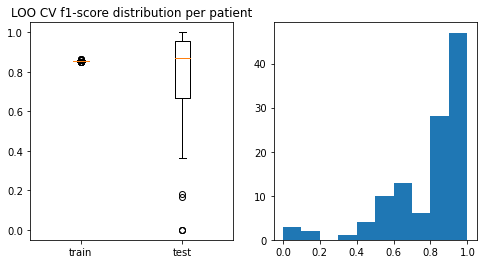

In [8]:
print('F1 scores median: ', np.median(f1_metrics, axis=0))
print('F1 scores mean: ', np.mean(f1_metrics, axis=0))

fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].boxplot(f1_metrics, labels=['train', 'test'])
ax[0].set_title('LOO CV f1-score distribution per patient')

ax[1].hist(np.array(f1_metrics)[:,1])
plt.show()

sensitivity for all candidates per patient
mean: 0.8869259162095094	median 1.0

#FP per candidate mean: 108.7719298245614 median: 69.0


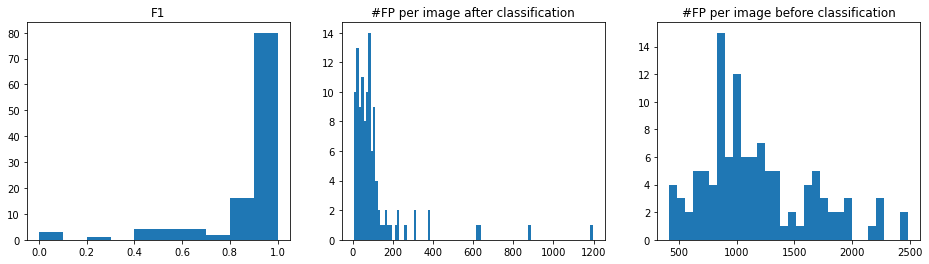

In [9]:
# sensitivity for all test candidates per patient
all_f1 = [sensitivity(x, y) for x, y in full_test_prediction]
print(f'sensitivity for all candidates per patient\nmean: {np.mean(all_f1)}\tmedian {np.median(all_f1)}')


FP_number_reduced = [np.sum(y&(~x)) for x, y in full_test_prediction]
FP_number_original = [len(y) - np.sum(x) for x, y in full_test_prediction]

print(f'\n#FP per candidate mean: {np.mean(FP_number_reduced)} median: {np.median(FP_number_reduced)}')


fig, ax = plt.subplots(1, 3, figsize=(16,4))

ax[0].hist(all_f1)
ax[0].set_title('F1')


ax[1].set_title('#FP per image after classification')
ax[1].hist(FP_number_reduced, bins=100)
ax[2].set_title('#FP per image before classification')
ax[2].hist(FP_number_original, bins=30)
plt.show()

In [42]:
froc_df = pd.concat(final_metrics_dfs)
froc_df

,candidate_coordinates,patch_coordinates,patch_mask_intersection,img_id,target,target_pred,target_pred_proba
1255,"[450, 1521, 3]","((1514, 1528), (443, 457))",0,20586908,0,0,0.057575
593,"[655, 1642, 16]","((1635, 1649), (648, 662))",0,20586908,0,0,0.087663
495,"[1247, 1342, 19]","((1335, 1349), (1240, 1254))",0,20586908,0,0,0.142958
1317,"[70, 2964, 3]","((2957, 2971), (63, 77))",0,20586908,0,0,0.094659
1346,"[49, 641, 3]","((634, 648), (42, 56))",0,20586908,0,0,0.120578
...,...,...,...,...,...,...,...
865,"[206, 1603, 3]","((1596, 1610), (199, 213))",0,30011674,0,0,0.246960
240,"[950, 1599, 19]","((1592, 1606), (943, 957))",0,30011674,0,0,0.170833
166,"[1121, 1834, 17]","((1827, 1841), (1114, 1128))",0,30011674,0,0,0.487445
341,"[956, 1415, 6]","((1408, 1422), (949, 963))",0,30011674,0,0,0.188755


In [43]:
pd.to_pickle(froc_df, 'dump.pkl')

In [5]:
froc_df = pd.read_pickle('dump.pkl')

froc_df (pd.DataFrame): containing all extracted and classifed patches information in columns, specifically 'img_id', 'patch_coordinates'

In [57]:
from general_utils.utils import crop_patch_around_center

center_crop_size = 14

froc_aggr_all = []
FN = []
for img_id in tqdm(froc_df.img_id.unique()):
    img_index = db.df[db.df.img_id == img_id].index.values[0]

    lesion_mask = db[img_index]['lesion_mask']

    image_froc_df = froc_df[froc_df.img_id == img_id]
    
    fp_patches = []
    tp_patches = []
    # iterating over patches and checking if the mask instersection is not zero
    tp_rois_dict = {}
    for patch_idx, patch in enumerate(image_froc_df.patch_coordinates.values):
        (px1, px2), (py1, py2) = patch
        
        # getting centre crop of the patch
        center_px1, center_px2, center_py1, center_py2 = crop_patch_around_center(py1, py2, px1, px2, center_crop_size)
        mask_rois_in_patch = set(lesion_mask[center_py1:center_py2, center_px1:center_px2].ravel()).difference(set([0]))

        if len(mask_rois_in_patch) == 0:
            patch_fp_dict =  image_froc_df.iloc[patch_idx].to_dict()
            patch_fp_dict['type'] = 'FP'
            fp_patches.append(patch_fp_dict)
        else:
            for mask_roi in mask_rois_in_patch:
                        
                if mask_roi not in tp_rois_dict.keys():
                    # saving information about matched to roi patch
                    tp_rois_dict[mask_roi] = image_froc_df.iloc[patch_idx].to_dict()
                    tp_rois_dict[mask_roi]['type'] = 'TP'
                else:
                    # rewriting match patch to roi if it has higher confidence
                    if image_froc_df.iloc[patch_idx]['target_pred_proba'] > tp_rois_dict[mask_roi]['target_pred_proba']:
                        tp_rois_dict[mask_roi] = image_froc_df.iloc[patch_idx].to_dict()
                        tp_rois_dict[mask_roi]['type'] = 'TP'

    tp_patches.extend(tp_rois_dict.values())
    froc_aggr_all.extend(fp_patches)
    froc_aggr_all.extend(tp_patches)
    FN.extend(set(lesion_mask.ravel()).difference(set([0])).difference(set(tp_rois_dict.keys())))

100%|██████████| 114/114 [01:04<00:00,  1.78it/s]


In [58]:
len(fp_patches)

883

In [34]:
# center_px1, center_px2, center_py1, center_py2 = crop_patch_around_center(py1, py2, px1, px2, center_crop_size)
(px1, px2), (py1, py2) = ((1308, 1322), (299, 313))	

p_center_y = py1 + (py2 - py1)//2
p_center_x = px1 + (px2 - px1)//2
center_px1, center_px2, center_py1, center_py2  = patch_coordinates_from_center((p_center_y, p_center_x), (2000, 2000), 7, use_padding=False)


In [35]:
center_px1, center_px2

(303, 310)

In [28]:
from general_utils.utils import crop_patch_around_center

In [31]:
center_px1, center_px2, center_py1, center_py2 = crop_patch_around_center(py1, py2, px1, px2, 7)

In [36]:
1, center_px2

(303, 310)

In [60]:
froc_aggr_all_df = pd.DataFrame(froc_aggr_all)
froc_aggr_all_df = froc_aggr_all_df.sort_values(by='target_pred_proba', ascending=False)
froc_aggr_all_df


,candidate_coordinates,patch_coordinates,patch_mask_intersection,img_id,target,target_pred,target_pred_proba,type
92973,"[306, 1315, 19]","((1308, 1322), (299, 313))",196,24055203,1,1,1.000000,TP
40378,"[290, 2199, 9]","((2192, 2206), (283, 297))",1,22579916,1,1,1.000000,TP
91665,"[462, 1489, 19]","((1482, 1496), (455, 469))",196,24055149,1,1,1.000000,TP
37979,"[367, 1334, 7]","((1327, 1341), (360, 374))",196,22579870,1,1,1.000000,TP
104112,"[1191, 1289, 8]","((1282, 1296), (1184, 1198))",1,24055627,1,1,1.000000,TP
...,...,...,...,...,...,...,...,...
126300,"[2, 1475, 3]","((1468, 1482), (0, 9))",0,26933801,0,0,0.000772,FP
23351,"[310, 1, 9]","((0, 8), (303, 317))",0,20588046,0,0,0.000526,FP
10573,"[1, 966, 3]","((959, 973), (0, 8))",0,20587372,0,0,0.000431,FP
10598,"[1, 1214, 10]","((1207, 1221), (0, 8))",0,20587372,0,0,0.000404,FP


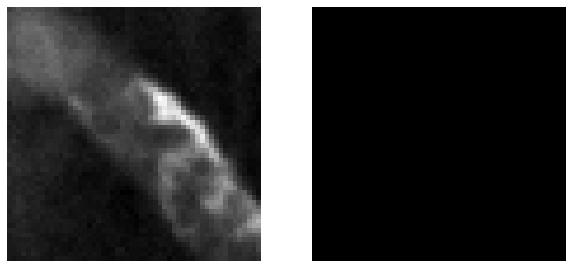

In [53]:
# quick snippet to check how predictions look

test_img_id = db.df[db.df.img_id == 20587612].index.values[0] #((2767, 2781), (1029, 1043))	
test_img = db[test_img_id]['img']
test_mask = db[test_img_id]['lesion_mask']
delta = 20
ppx1, ppx2, ppy1, ppy2 = 2115, 2129, 1657, 1671
simple_im_show2(test_img[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta], test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta])

In [54]:
# calculating final FROC curve points

tprs = []
fpis = []
for i in tqdm(range(1, len(froc_aggr_all_df))):
    df_slice = froc_aggr_all_df.type.values[:i]
    tp_count = (df_slice == 'TP').sum()
    fp_count = (df_slice == 'FP').sum()
    tpr = tp_count/(tp_count + len(FN))
    fpi = fp_count/(149)
    
    tprs.append(tpr)
    fpis.append(fpi)
    
    if fpi > 50:
        break

  6%|▌         | 8374/134443 [00:01<00:18, 6931.38it/s] 


In [5]:
froc_df = pd.read_pickle('dump.pkl')

In [6]:
froc_df = froc_df.rename(columns={'target_pred_proba':'confidence'})

In [7]:
tprs, fpis, froc_aggr_all_df, total_mC = get_froc(froc_df, db, 7)

100%|██████████| 114/114 [01:05<00:00,  1.74it/s]


In [12]:
def plot_froc(fpis, tprs, total_mC, label=''):
    plt.figure(figsize=(8, 8))
    plt.xlabel('FPpI')
    plt.ylabel(f'TPR ({total_mC}) mC')
    plt.title('FROC curve')
    plt.plot(fpis, tprs)
    plt.ylim((0, 1))
    plt.legend([f"{label} AUC: {auc(fpis, tprs)}"])
    plt.show()

In [56]:
print(f"AUC: {auc(fpis, tprs)}")

AUC: 27.80626881881464
